In [1]:
from utils.pkl_preprocessor import PickleBatchLoader
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


# Using XG-Boost


In [2]:
def train_xgboost_incrementally(batch_loader):
    """
    Function to train XGBoost incrementally on batches from a loader.
    This version corrects the incremental training logic.
    """
    # 1. Instantiate the classifier ONCE before the loop.
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
    )

    # This will hold the trained Booster object from the previous iteration.
    trained_booster = None

    print("--- Starting Incremental XGBoost Training ---")

    # 2. Loop through batches
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training XGBoost on batch {i + 1}/{len(batch_loader)}...")

        # For the first batch, trained_booster is None.
        # For subsequent batches, it's the model from the last step.
        model.fit(X_batch, y_batch, xgb_model=trained_booster)

        # 3. Get the underlying booster to pass to the next iteration
        trained_booster = model.get_booster()

    # 4. Evaluation on the hold-out test set
    print("  Evaluating final XGBoost model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy * 100


# Using Random Forset


In [3]:
def train_random_forest_incrementally(batch_loader):
    """
    Function to train Random Forest using warm_start on batches.
    """
    # warm_start=True is key for incremental additions
    rf_model = RandomForestClassifier(n_estimators=5, random_state=42, warm_start=True)
    print("--- Starting Incremental Random Forest Training ---")

    # Training loop
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training Random Forest on batch {i + 1}/{len(batch_loader)}...")
        rf_model.fit(X_batch, y_batch)
        # Increase the number of estimators for the next batch
        rf_model.n_estimators += 5

    # Evaluation on the hold-out test set
    print("  Evaluating final Random Forest model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy * 100


# Using Gradient Boosting


In [4]:
def train_gradient_boosting_incrementally(batch_loader):
    """
    Function to train Gradient Boosting using warm_start on batches.
    """
    # warm_start=True is key for incremental additions
    gb_model = GradientBoostingClassifier(
        n_estimators=5, learning_rate=0.1, max_depth=6, random_state=42, warm_start=True
    )
    print("--- Starting Incremental Gradient Boosting Training ---")

    # Training loop
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training Gradient Boosting on batch {i + 1}/{len(batch_loader)}...")
        gb_model.fit(X_batch, y_batch)
        # Increase the number of estimators for the next batch
        gb_model.n_estimators += 5

    # Evaluation on the hold-out test set
    print("  Evaluating final Gradient Boosting model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = gb_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy * 100


In [5]:
delta = 106

In [6]:
from utils.sm4 import sm4_encryption_binary
import pandas as pd
import numpy as np
from pathlib import Path
import random

random.seed(42)
mk = random.getrandbits(128)


In [ ]:

for rounds in range(1, 33, 1):
    PICKLE_DIR = Path(f"SM4_Output_Flipped_Bits_round_{rounds}")
    PICKLE_DIR.mkdir(parents=True, exist_ok=True)
    print("=========================================================")
    print(f"Processing round {rounds}...")
    print("=========================================================")

    all_rows_data = []
    df = pd.read_pickle(f"flipped_bits_raw/bit_flipped_delta-{delta}.pkl")
    P1 = df["P1"].values
    P2 = df["P2"].values
    for i in range(100096):
        plain_text_1 = P1[i]
        plain_text_2 = P2[i]
        C1 = sm4_encryption_binary(plain_text_1, mk, rounds)
        C2 = sm4_encryption_binary(plain_text_2, mk, rounds)
        C = result = np.concatenate([C1, C2])
        all_rows_data.append({"Encrypted_data": C, "Class": "flipped_bits"})
    df = pd.DataFrame(all_rows_data)
    df.to_pickle(
        f"SM4_Output_Flipped_Bits_round_{rounds}/SM4_{rounds}_round_delta-{delta}.pkl"
    )


In [7]:
for rounds in range(1, 33, 1):
    DIR = Path(f"dataset_pkl_round_{rounds}")
    DIR.mkdir(exist_ok=True)
    delta = 106
    df_sm4_flipped = pd.read_pickle(
        f"SM4_Output_Flipped_Bits_round_{rounds}/SM4_{rounds}_round_delta-{delta}.pkl"
    )
    df_sm4_diff = pd.read_pickle(f"SM4_Output_Diff_Bits/SM4_{rounds}_round.pkl")

    df_combined = pd.concat([df_sm4_flipped, df_sm4_diff], ignore_index=True)
    df_combined.to_pickle(
        f"dataset_pkl_round_{rounds}/SM4_{rounds}_round_delta-{delta}_combined.pkl"
    )


In [12]:
BATCH_SIZE = 100096
rounds_list = []
xgboost_accuracies = []
random_forest_accuracies = []
gradient_boosting_accuracies = []
for rounds in range(1, 33, 1):
    print("\n========================================================")
    print(f"Processing Round {rounds} from file")
    print("========================================================\n")
    delta = 106
    pickle_file = (
        f"dataset_pkl_round_{rounds}/SM4_{rounds}_round_delta-{delta}_combined.pkl"
    )
    print("\n========================================================")
    print(f"Processing Delta {delta}/128 from file: {pickle_file}")
    print("========================================================\n")
    try:
        batch_loader = PickleBatchLoader(pickle_file, batch_size=BATCH_SIZE)
        xgboost_accuracy = train_xgboost_incrementally(batch_loader)
        random_forest_accuracy = train_random_forest_incrementally(batch_loader)
        gradient_boosting_accuracy = train_gradient_boosting_incrementally(batch_loader)

        rounds_list.append(rounds)
        xgboost_accuracies.append(xgboost_accuracy)
        random_forest_accuracies.append(random_forest_accuracy)
        gradient_boosting_accuracies.append(gradient_boosting_accuracy)
        print(
            f"\nRound {rounds} Completed | "
            f"Final XGBoost Accuracy: {xgboost_accuracy:.4f}%\n"
            f"Final Random Forest Accuracy: {random_forest_accuracy:.4f}%\n"
            f"Final Gradient Boosting Accuracy: {gradient_boosting_accuracy:.4f}%\n"
        )
    except FileNotFoundError:
        print(f"File not found: {pickle_file}. Skipping round {rounds}.")
        continue
    except Exception as e:
        print(f"An error occurred during round {rounds}: {e}")
        continue

results_df = pd.DataFrame(
    {
        "Rounds": rounds_list,
        "XGBoost_Accuracy": xgboost_accuracies,
        "RandomForest_Accuracy": random_forest_accuracies,
        "GradientBoosting_Accuracy": gradient_boosting_accuracies,
    }
)
results_df.set_index("Rounds", inplace=True)
print("\nFinal Results DataFrame:")
print(results_df)
results_df.to_pickle("model_accuracy_results_incremental_delta_106.pkl")
results_df.to_csv("model_accuracy_results_incremental_delta_106.csv")
print(
    "\nDataFrame saved as 'model_accuracy_results_incremental_delta_106.pkl' and .csv"
)



Processing Round 1 from file


Processing Delta 106/128 from file: dataset_pkl_round_1/SM4_1_round_delta-106_combined.pkl

Loading data from dataset_pkl_round_1/SM4_1_round_delta-106_combined.pkl...
Preprocessing hold-out test set...
Loader initialized. Ready to generate batches.
--- Starting Incremental XGBoost Training ---
  Training XGBoost on batch 1/2...
  Training XGBoost on batch 2/2...
  Evaluating final XGBoost model...
--- Starting Incremental Random Forest Training ---
  Training Random Forest on batch 1/2...
  Training Random Forest on batch 2/2...
  Evaluating final Random Forest model...
--- Starting Incremental Gradient Boosting Training ---
  Training Gradient Boosting on batch 1/2...
  Training Gradient Boosting on batch 2/2...
  Evaluating final Gradient Boosting model...

Round 1 Completed | Final XGBoost Accuracy: 100.0000%
Final Random Forest Accuracy: 99.5929%
Final Gradient Boosting Accuracy: 99.2757%


Processing Round 2 from file


Processing Delta 106/128 fro

# Code to Plot Graphs


In [6]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
results_df = pd.read_pickle("model_accuracy_results_incremental_delta_106.pkl")

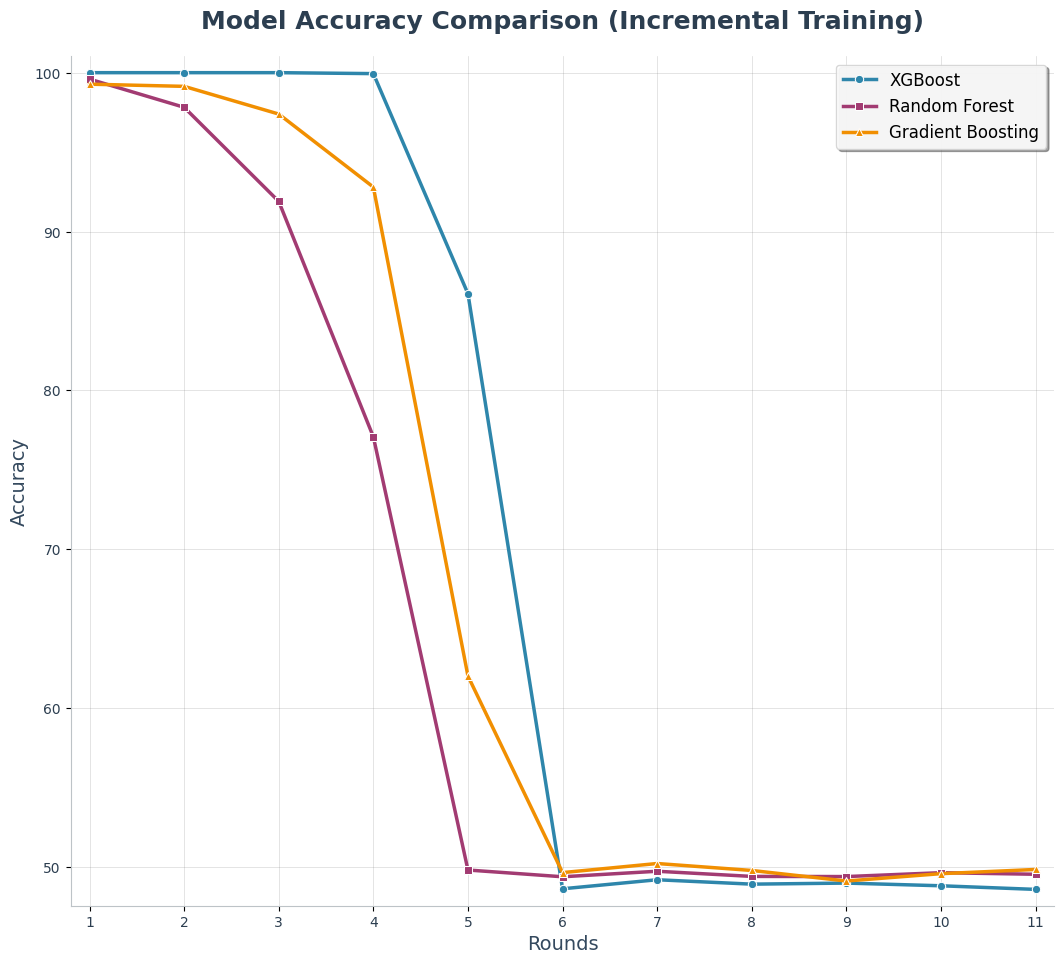

Enhanced plot saved as 'model_accuracy_comparison_incremental_delta-106.png'


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clean, aesthetic look
plt.style.use("default")  # Reset to default style
sns.set_palette("husl")  # Use a more aesthetic color palette

plt.figure(figsize=(11, 10), facecolor="white")
plot_df = results_df.reset_index()

plot_df_filtered = plot_df[plot_df["Rounds"] <= 11]

# Create the plot with enhanced aesthetics
ax = plt.gca()
ax.set_facecolor("white")  # Ensure plot background is white

# Plot XGBoost with enhanced styling
sns.lineplot(
    data=plot_df_filtered,
    x="Rounds",
    y="XGBoost_Accuracy",
    marker="o",
    label="XGBoost",
    linewidth=2.5,
    markersize=6,
    color="#2E86AB",  # Professional blue color
)

sns.lineplot(
    data=plot_df_filtered,
    x="Rounds",
    y="RandomForest_Accuracy",
    marker="s",
    label="Random Forest",
    linewidth=2.5,
    markersize=6,
    color="#A23B72",  # Professional magenta
)
sns.lineplot(
    data=plot_df_filtered,
    x="Rounds",
    y="GradientBoosting_Accuracy",
    marker="^",
    label="Gradient Boosting",
    linewidth=2.5,
    markersize=6,
    color="#F18F01",  # Professional orange
)

# Enhanced title and labels
plt.title(
    "Model Accuracy Comparison (Incremental Training)",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",  # Dark blue-gray color
    pad=20,
)
plt.xlabel("Rounds", fontsize=14, fontweight="medium", color="#34495e")
plt.ylabel("Accuracy", fontsize=14, fontweight="medium", color="#34495e")

# Enhanced legend
plt.legend(
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    facecolor="white",
    edgecolor="lightgray",
    framealpha=0.9,
)

# Improved grid
plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, color="gray")

# Enhanced tick styling
plt.xticks(range(1, 12, 1), fontsize=10, color="#2c3e50")
plt.yticks(fontsize=10, color="#2c3e50")

# Remove top and right spines for cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("#bdc3c7")
ax.spines["bottom"].set_color("#bdc3c7")

# Set white background for the entire figure
plt.gcf().patch.set_facecolor("white")

# Reduce whitespace around the plot
plt.margins(x=0.02, y=0.02)
plt.tight_layout(pad=2.0)

# Save with white background
plt.savefig(
    f"model_accuracy_comparison_incremental_delta-{delta}.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",  # Ensure saved image has white background
    edgecolor="none",
)
plt.show()
print(
    f"Enhanced plot saved as 'model_accuracy_comparison_incremental_delta-{delta}.png'"
)
